In [1]:
!pip3 install -U pytorch-optimizer
!pip install -U "anc2vec @ git+https://github.com/aedera/anc2vec.git"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 kB 8.6 MB/s eta 0:00:00
  Cloning https://github.com/aedera/anc2vec.git to /tmp/pip-install-hfje3eq1/anc2vec_5e5c935ce0c54fc88c3e9892b5f74a5b
  Running command git clone --filter=blob:none --quiet https://github.com/aedera/anc2vec.git /tmp/pip-install-hfje3eq1/anc2vec_5e5c935ce0c54fc88c3e9892b5f74a5b
  Resolved https://github.com/aedera/anc2vec.git to commit d828ad7ce9606e98cd349a5c48d6fc825edcf4c1
  Installing build dependencies ... - \ | done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of anc2vec to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement tensorflow<2.5,>=2.3.1 (from anc2vec) (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1

In [2]:
import os
import gc
import time
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingLR
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy
from pytorch_optimizer import Ranger, SoftF1Loss

from sklearn.metrics import roc_auc_score

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
CONFIG = {"root_data": '/kaggle/input/cafa-5-protein-function-prediction',
          "root_embed": '/kaggle/input/23468234',
          "exp_name": 'all, 600 label, 250 iter, sigmoid cosine, seed : 42',
          "n_labels": 600,
          "seeds": [42],
          "min_ia": 1,
          "epoch": 250,
          "lr": 1e-3,
          "batch_size": 256,
          "n_accumulate": 1,
          "loss": 'cce', # 'cce', 'sigmoidf1' 'softf1'
          "scheduler": 'cosine', # 'cosine', 'onecycle'
          "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu')}

In [4]:
print("## Experiment: ")
print(CONFIG['exp_name'])

## Experiment: 
all, 600 label, 250 iter, sigmoid cosine, seed : 42


In [5]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

## Get Train Terms & Load Embeddings 

In [6]:
train_data = pd.read_csv(os.path.join(CONFIG["root_data"], 'Train', 'train_terms.tsv'), sep='\t')
IA = pd.read_csv(os.path.join(CONFIG["root_data"], 'IA.txt'), sep='\t', header=None, names=["term", "val"])
IA = IA[IA["val"] > CONFIG["min_ia"]].reset_index().drop(["index"], axis=1)
IA = IA["term"].values

In [7]:
ids = np.load('/kaggle/input/4637427/train_ids_esm2_t36_3B_UR50D.npy')
labels = train_data

top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
labels_names = top_terms[:CONFIG["n_labels"]].index.values
train_labels_sub = labels[(labels.term.isin(labels_names)) & (labels.EntryID.isin(ids))]
id_labels = train_labels_sub.groupby('EntryID')['term'].apply(list).to_dict()

go_terms_map = {label: i for i, label in enumerate(labels_names)}
labels_matrix = np.empty((len(ids), len(labels_names)))

for index, id in tqdm(enumerate(ids), total=len(ids)):
    id_gos_list = id_labels[id]
    temp = [go_terms_map[go] for go in labels_names if go in id_gos_list]
    labels_matrix[index, temp] = 1
    
print(labels_matrix)
print(labels_matrix.shape)

np.save("/kaggle/working/train_targets_top"+str(CONFIG["n_labels"])+".npy", np.array(labels_matrix))

del labels_matrix
_ = gc.collect()

100%|██████████| 142246/142246 [01:17<00:00, 1827.30it/s]


[[0. 1. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 1.]]
(142246, 600)


## Dataset

In [8]:
class ProteinDataset(Dataset):
    def __init__(self, ids_source, embedding_source1, embedding_source2, target_source, train=True):
        ids = np.load(ids_source)
        if embedding_source2 is not None:
            embeds1 = np.load(embedding_source1)
            embeds2 = np.load(embedding_source2)
            embeds = np.concatenate((embeds1, embeds2), axis=1)

            del embeds1, embeds2
            gc.collect()
            
            print(embeds.shape)
        
        else:
            embeds = np.load(embedding_source1)
        
        self.train = train
        
        embeds_list = []
        for l in range(embeds.shape[0]):
            embeds_list.append(embeds[l,:])
            
        self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})
        
        if self.train:
            target = np.load(target_source)
            df_labels = pd.DataFrame({"EntryID": ids, "target": target.tolist()})
            del target
            gc.collect()
            self.df = self.df.merge(df_labels, on="EntryID")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
        if self.train:
            target = torch.tensor(self.df.iloc[index]["target"], dtype = torch.float32)
            return {
                'embed': embed,
                'target': target,
            }
        else:
            id = self.df.iloc[index]["EntryID"]
            return { 
                'embed': embed,
                'id' : id
            }

## Model

In [9]:
class LinearModel(nn.Module):
    def __init__(self, embed_size, hidden_size1, hidden_size2, target_size, dropout=0.8, num_emb_layers=2):
        super(LinearModel, self).__init__()
        self.input_block = nn.Sequential(nn.LayerNorm(embed_size, eps=1e-6),
                                         nn.Linear(embed_size, hidden_size1), 
                                         nn.LeakyReLU())

        self.hidden_block1 = []
        for i in range(num_emb_layers - 1):
            self.hidden_block1.extend([nn.LayerNorm(hidden_size1, eps=1e-6), 
                                       nn.Dropout(0.15), 
                                       nn.Linear(hidden_size1, hidden_size1), 
                                       nn.LeakyReLU()])
            
            if i == num_emb_layers - 2:
                self.hidden_block1.extend([nn.LayerNorm(hidden_size1, eps=1e-6)])
        self.hidden_block1.extend([nn.LayerNorm(hidden_size1, eps=1e-6), 
                                   nn.Dropout(0.15), 
                                   nn.Linear(hidden_size1, hidden_size2)])
        self.hidden_block1 = nn.Sequential(*self.hidden_block1)
        
        self.hidden_block2 = []
        for i in range(num_emb_layers - 1):
            self.hidden_block2.extend([nn.LayerNorm(hidden_size2, eps=1e-6), 
                                       nn.Dropout(0.15), 
                                       nn.Linear(hidden_size2, hidden_size2), 
                                       nn.LeakyReLU()])
            
            if i == num_emb_layers - 2:
                self.hidden_block2.extend([nn.LayerNorm(hidden_size2, eps=1e-6)])
        self.hidden_block2 = nn.Sequential(*self.hidden_block2)
        
        self.output_block = nn.Sequential(nn.LayerNorm(hidden_size2, eps=1e-6), 
                                          nn.Dropout(0.15), 
                                          nn.Linear(hidden_size2, target_size))
        
        self.dropout = nn.Dropout(dropout)
        
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        
    def forward(self, x):        
        out = self.input_block(x)
        out = self.dropout(self.hidden_block1(out))
        out = self.dropout(self.hidden_block2(out))
        out = self.output_block(out)
        return out

In [10]:
# https://github.com/gabriben/metrics-as-losses
class sigmoidF1(nn.Module):

    def __init__(self, S = -1, E = 0):
        super(sigmoidF1, self).__init__()
        self.S = S
        self.E = E

    @torch.cuda.amp.autocast()
    def forward(self, y_hat, y):
        
        y_hat = torch.sigmoid(y_hat)

        b = torch.tensor(self.S)
        c = torch.tensor(self.E)

        sig = 1 / (1 + torch.exp(b * (y_hat + c)))

        tp = torch.sum(sig * y, dim=0)
        fp = torch.sum(sig * (1 - y), dim=0)
        fn = torch.sum((1 - sig) * y, dim=0)

        sigmoid_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
        cost = 1 - sigmoid_f1
        macroCost = torch.mean(cost)

        return macroCost

In [11]:
def criterion(output, target):
    if CONFIG['loss'] == "softf1":
        loss = SoftF1Loss()
    elif CONFIG['loss'] == "cce":
        loss = nn.CrossEntropyLoss(label_smoothing=0.1)
    elif CONFIG['loss'] == "sigmoidf1":
        loss = sigmoidF1()
    else:
        raise NotImplementedError
    return loss(output, target)

In [12]:
def f1score(output, target):
    score = MultilabelF1Score(num_labels=CONFIG['n_labels']).to(CONFIG['device'])
    return score(output, target)

## Training

In [13]:
def train_one_epoch(model, optimizer, scheduler, dataloader, epoch, verbose):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    running_score = 0.0
    
    #bar = tqdm(enumerate(dataloader), total=len(dataloader), leave=verbose)
    for step, data in enumerate(dataloader):
        embeds = data['embed'].to(CONFIG['device'])
        targets = data['target'].to(CONFIG['device'])
        batch_size = embeds.size(0)
        
        preds = model(embeds)
        
        score = f1score(preds, targets)
        loss = criterion(preds, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()
            optimizer.zero_grad()
            
            if scheduler is not None:
                scheduler.step(epoch_loss)
                
        running_loss += (loss.item() * batch_size)
        running_score += (score.item() * batch_size)
        dataset_size += batch_size
        
    epoch_loss = running_loss / dataset_size
    epoch_score = running_score / dataset_size
        
#     bar.set_postfix(Epoch=epoch, 
#                     Train_Loss=epoch_loss,
#                     LR=optimizer.param_groups[0]['lr'])
        
    # garbage collection
    gc.collect()
    
    return epoch_loss, epoch_score

In [14]:
@torch.no_grad()

def valid_one_epoch(model, optimizer, dataloader, scheduler, epoch, verbose):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_score = 0.0
    
    #bar = tqdm(enumerate(dataloader), total=len(dataloader), leave=verbose)
    for step, data in enumerate(dataloader):        
        embeds = data['embed'].to(CONFIG['device'])
        targets = data['target'].to(CONFIG['device'])
        batch_size = embeds.size(0)
        
        preds = model(embeds)
        
        score = f1score(preds, targets)
        loss = criterion(preds, targets)
        loss = loss / CONFIG['n_accumulate']
        
        running_loss += (loss.item() * batch_size)
        running_score += (score.item() * batch_size)
        dataset_size += batch_size
        
    epoch_loss = running_loss / dataset_size
    epoch_score = running_score / dataset_size
        
#     bar.set_postfix(Epoch=epoch, 
#                     Valid_Loss=epoch_loss,
#                     LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    
    return epoch_loss, epoch_score

In [15]:
def run_training(model, optimizer, scheduler, train_loader, val_loader, num_epochs, verbose=True):
    train_score = []
    val_score = []
    train_loss = []
    val_loss = []
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_score = 0.0                                                                                             
    
    for epoch in range(num_epochs):
        if verbose:
            print(f"Epoch: {epoch}")
            
        gc.collect()
        train_epoch_loss, train_epoch_score = train_one_epoch(model=model, 
                                                              optimizer=optimizer, 
                                                              scheduler=scheduler, 
                                                              dataloader=train_loader,  
                                                              epoch=epoch,
                                                              verbose=verbose)
        train_score.append(train_epoch_score)
        train_loss.append(train_epoch_loss)
        
        if val_loader is not None:                                                                      
            val_epoch_loss, val_epoch_score = valid_one_epoch(model=model, 
                                                              optimizer=optimizer,
                                                              dataloader=val_loader, 
                                                              scheduler=scheduler,
                                                              epoch=epoch,
                                                              verbose=verbose)

            val_score.append(val_epoch_score)
            val_loss.append(val_epoch_loss)
            if verbose:
                print(f"Train loss: {train_epoch_loss} Validation loss: {val_epoch_loss}")
                print(f"Train score: {train_epoch_score} Validation score: {val_epoch_score}")

            if val_epoch_score >= best_epoch_score:
                if verbose:
                    print(f"Validation Loss Improved ({best_epoch_score} ---> {val_epoch_loss})")

                best_epoch_loss = val_epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

            print()
        
        else:
            val_score = None
            val_loss = None
            if verbose:
                print(f"Train loss: {train_epoch_loss}")
                print(f"Train score: {train_epoch_score}")
            
            if train_epoch_score >= best_epoch_score:
                if verbose:
                    print(f"Score Improved ({best_epoch_score} ---> {train_epoch_score})")
                best_model_wts = copy.deepcopy(model.state_dict())
                                                                                                  
        end = time.time()
                                                                                                  
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    
    print("Best Score: {:.4f}".format(best_epoch_score))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_score, train_loss, val_score, val_loss                                                                         

## Run Training

In [16]:
def run_folds(folds, data='all', save_output=True):
    num_labels = CONFIG['n_labels']
    
    print("## Loading Dataset")
    dataset = ProteinDataset(ids_source='/kaggle/input/4637427/train_ids_esm2_t36_3B_UR50D.npy',
                             embedding_source1='/kaggle/input/23468234/train_embeds_esm2_t33_650M_UR50D.npy',
                             embedding_source2='/kaggle/input/t5embeds/train_embeds.npy',
                             target_source=f"/kaggle/working/train_targets_top{num_labels}.npy",
                             train=True)
    train_losses = []
    train_scores = []
    val_losses = []
    val_scores = []
    
    print("## Running Training")
    
    for seed in folds:
        set_seed(seed)
        print("#### Seed: ", seed, "####")
        print()
        if data != 'all':
            generator = torch.Generator().manual_seed(seed)
            train_dataset, val_dataset = random_split(dataset, 
                                                      lengths = [int(len(dataset)*0.9), 
                                                                 len(dataset)-int(len(dataset)*0.9)],
                                                      generator=generator)

            train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=CONFIG['batch_size'], num_workers=2, shuffle=True)
            val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=CONFIG['batch_size'], num_workers=2, shuffle=False)
            
        else:
            train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=CONFIG['batch_size'], num_workers=2, shuffle=True)
            val_dataloader = None
            
        model = LinearModel(embed_size=2304, 
                            hidden_size1=1912,
                            hidden_size2=1024,
                            target_size=CONFIG['n_labels'], 
                            dropout=0.8, 
                            num_emb_layers=3).to(CONFIG['device'])

        optimizer = Ranger(model.parameters(), lr=CONFIG['lr']) 
        
        if CONFIG['scheduler'] == 'cosine':
            scheduler = CosineAnnealingLR(optimizer, (CONFIG['epoch'] * 501))
        elif CONFIG['scheduler'] == 'onecycle':
            scheduler = OneCycleLR(optimizer, max_lr=CONFIG['lr'], total_steps=CONFIG['epoch'] * 501)

        model, train_score, train_loss, val_score, val_loss = run_training(model=model, 
                                                                           optimizer=optimizer, 
                                                                           scheduler=None, 
                                                                           train_loader=train_dataloader, 
                                                                           val_loader=val_dataloader,
                                                                           num_epochs=CONFIG['epoch'], 
                                                                           verbose=True)
        
        train_losses.append(train_loss)
        train_scores.append(train_score)
        val_losses.append(val_loss)
        val_scores.append(val_score)
        
        if save_output:
            root_save = "/kaggle/working/"
            os.makedirs(os.path.dirname(f"{root_save}/model_{seed}.pt"), exist_ok=True)
            torch.save(model.state_dict(), f"{root_save}/model_{seed}.pt")
        
        del model, train_dataloader, val_dataloader, train_score, train_loss, val_score, val_loss
        _ = gc.collect()
        
    return train_losses, train_scores, val_losses, val_scores

In [17]:
train_losses, train_scores, val_losses, val_scores = run_folds(folds=CONFIG['seeds'],
                                                               data="all",
                                                               save_output=True)

## Loading Dataset
(142246, 2304)
## Running Training
#### Seed:  42 ####

Epoch: 0
Train loss: 144.75735007886075
Train score: 0.07281005254274257
Score Improved (0.0 ---> 0.07281005254274257)
Epoch: 1
Train loss: 133.7402452596229
Train score: 0.09324490400759396
Score Improved (0.0 ---> 0.09324490400759396)
Epoch: 2
Train loss: 130.02964778145125
Train score: 0.11598902183173687
Score Improved (0.0 ---> 0.11598902183173687)
Epoch: 3
Train loss: 128.24593204476676
Train score: 0.12253575097280445
Score Improved (0.0 ---> 0.12253575097280445)
Epoch: 4
Train loss: 127.14104035977962
Train score: 0.1262848566815691
Score Improved (0.0 ---> 0.1262848566815691)
Epoch: 5
Train loss: 126.23439418992838
Train score: 0.1300298552724194
Score Improved (0.0 ---> 0.1300298552724194)
Epoch: 6
Train loss: 125.518553835451
Train score: 0.13289363480383756
Score Improved (0.0 ---> 0.13289363480383756)
Epoch: 7
Train loss: 124.84073857372239
Train score: 0.13579785334840677
Score Improved (0.0 ---> 0

In [18]:
print(train_losses[0])
if val_losses[0] is not None:
    print(val_losses[0])

[144.75735007886075, 133.7402452596229, 130.02964778145125, 128.24593204476676, 127.14104035977962, 126.23439418992838, 125.518553835451, 124.84073857372239, 124.21396774708845, 123.62086684472894, 123.01945785439433, 122.44435828107164, 121.92723484837667, 121.43268219595284, 120.93314523647153, 120.4439325264659, 120.04736696169833, 119.60218156106295, 119.18148730059063, 118.7392321317454, 118.44408021746156, 118.05948575733734, 117.75104442241532, 117.45156485033795, 117.1337077625657, 116.82746088331986, 116.55933358125789, 116.27580536014393, 116.03768067422745, 115.77704047344164, 115.51804789545069, 115.33368515197652, 115.1967227409576, 114.89551888817152, 114.7399267894959, 114.5418406655556, 114.34201997903624, 114.18823682339513, 114.00048096411967, 113.8205800366268, 113.71377376160945, 113.51004548807148, 113.3891170405112, 113.24273215067906, 113.08265991519876, 112.93665909414834, 112.80242168406723, 112.69906844975849, 112.50710115354566, 112.411410951843, 112.32434377

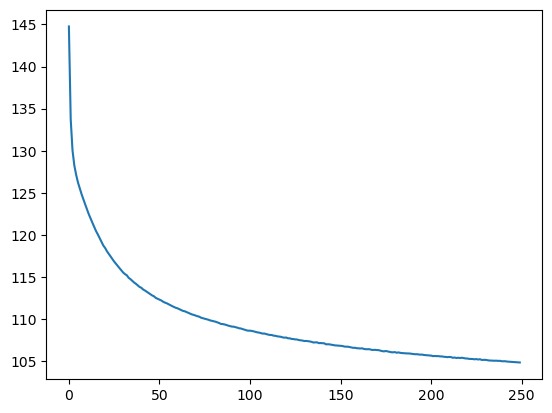

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses[0])
if val_losses[0] is not None:
    plt.plot(val_losses[0])
plt.show()

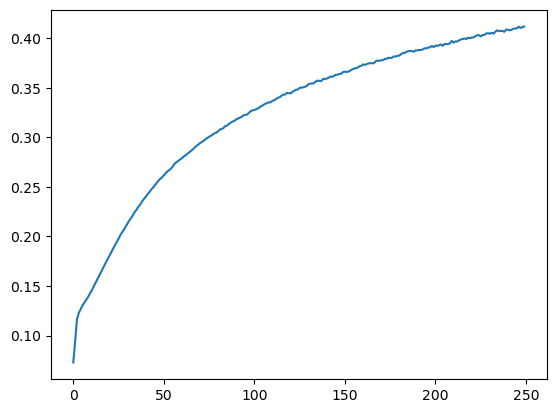

In [20]:
plt.figure()
plt.plot(train_scores[0])
if val_scores[0] is not None:
    plt.plot(val_scores[0])
plt.show()

In [21]:
os.remove("/kaggle/working/train_targets_top"+str(CONFIG["n_labels"])+".npy")